# Airbnb Superhost: Model Selection for Logistic Regression

## Part 1: Load the Data Set

For this project, we will work with a Airbnb NYC "listings" data set, pre-processed using SQL. 

The goal of this project is to build a logistic regression model that predicts whether an Airbnb host is a superhost or not, using a wide range of features.

In [2]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve

In [3]:
filename = os.path.join(os.getcwd(), "data", "airbnb_readytofit.csv.gz")
df= pd.read_csv(filename, header=0)

## Part 2: Create Training and Test Data Sets

First, we will store the label column as a separate object, called `y`, and consequently remove that column from the `X` feature set.

In [4]:
y= df["host_is_superhost"]
X= df.drop(columns = 'host_is_superhost', axis=1)

Then, we split the labeled examples into training and test sets.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1234)

In [6]:
X_train.head()

,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,...,n_host_verifications,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
326,True,True,True,False,-0.868049,-2.706229,-0.120567,-0.120567,-0.470102,-0.337606,...,-0.083566,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
26890,True,False,True,False,0.578052,1.010024,-0.120567,-0.120567,0.605041,-0.337606,...,-1.562519,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
16767,True,True,True,False,0.578052,0.638399,-0.112284,-0.112284,-0.470102,-0.337606,...,1.395388,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27743,True,True,True,True,0.288832,1.010024,-0.120567,-0.120567,2.755328,2.036990,...,-1.562519,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9783,True,False,True,False,0.578052,1.010024,-0.104000,-0.104000,0.605041,-0.337606,...,-1.069535,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## Part 3: Fit and Evaluate a Logistic Regression Model with Default Hyperparameter Values

Now, we create a Logistic Regression model object and fit the model to the training data.

In [7]:
model_default= LogisticRegression(max_iter=1000)
model_default.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Next, we test our model on the test set (`X_test`) to evaluate the model performance.

In [8]:
proba_predictions_default= model_default.predict_proba(X_test)[:,1]
class_label_predictions_default= model_default.predict(X_test)

We evaluate the accuracy of the model using a confusion matrix.

In [9]:
pd.DataFrame(confusion_matrix(y_test, class_label_predictions_default, labels=[True, False]), columns=['Predicted: Superhost', 'Predicted: Not Superhost'], 
             index=['Actual: Superhost', 'Actual: Not Superhost'])

,Predicted: Superhost,Predicted: Not Superhost
Actual: Superhost,265,450
Actual: Not Superhost,91,1997


## Part 4: Perform Logisitic Regression Model Selection

Our goal is to find the optimal choice of hyperparameter $C$. To do this, we need to set up a paramter grid using scikit-learn.

In [10]:
from sklearn.svm import l1_min_c

cs = l1_min_c(X_train, y_train, loss="log") * np.logspace(0, 7, 16)
param_grid = dict(C = list(cs))
param_grid

{'C': [0.0001537633581917429,
  0.0004503182232067712,
  0.0013188220167462046,
  0.0038623609310518637,
  0.011311482347345912,
  0.03312731129440893,
  0.09701812016301883,
  0.28413159028558327,
  0.8321204375281983,
  2.436984996480532,
  7.137062864015964,
  20.901920364088983,
  61.214295464518635,
  179.2749136895258,
  525.0325015504883,
  1537.633581917429]}

Now, we use `GridSearchCV()` to search over the different values of hyperparameter $C$ to find the one that results in the best 5-fold cross-validation (CV) score.

In [11]:
print('Running Grid Search...')

model= LogisticRegression(max_iter=1000)

grid = GridSearchCV(model, param_grid, cv=5)

grid_search = grid.fit(X_train, y_train)

print('Done')

Running Grid Search...
Done


Then, we retrieve the value of the hyperparameter $C$ for which the best score was attained.

In [12]:
best_c= grid_search.best_estimator_.C
best_c

525.0325015504883

## Part 5: Fit and Evaluate the Optimal Logisitic Regression Model 

Next, we refit the model to the training data using the best value of hyperparameter `C`.

In [13]:
model_best = LogisticRegression(C=best_c, max_iter=1000)
model_best.fit(X_train, y_train)

LogisticRegression(C=525.0325015504883, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We again test our model on the test set (`X_test`).

In [14]:
proba_predictions_best= model_best.predict_proba(X_test)[:,1]
class_label_predictions_best= model_best.predict(X_test)

Then, we re-evaluate the accuracy of the model using a confusion matrix.

In [15]:
pd.DataFrame(confusion_matrix(y_test, class_label_predictions_best, labels=[True, False]), columns=['Predicted: Superhost', 'Predicted: Not Superhost'], 
             index=['Actual: Superhost', 'Actual: Not Superhost'])

,Predicted: Superhost,Predicted: Not Superhost
Actual: Superhost,270,445
Actual: Not Superhost,88,2000


## Part 6:  Plot Precision-Recall Curves for Both Models

Next, we compute the precision-recall pairs for both the original and the updated models.

In [18]:
precision_default, recall_default, thresholds_default = precision_recall_curve(y_test, proba_predictions_default)
precision_best, recall_best, thresholds_best = precision_recall_curve(y_test, proba_predictions_best)

array([1.       , 0.9986014, 0.9986014, ..., 0.       , 0.       ,
       0.       ])

Then, we use `seaborn` to create lineplots to visualize the precision-recall curve for both models. Note that the plot for original model is in green, and the plot for the updated model is in red.

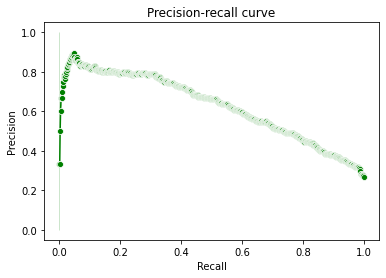

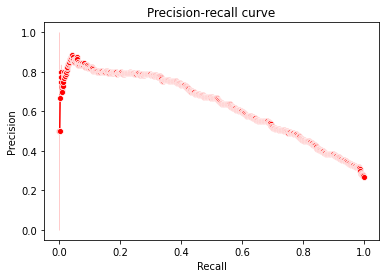

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x=recall_default, y=precision_default, marker = 'o', color='green')

plt.title("Precision-recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x=recall_best, y=precision_best, marker = 'o', color='red')

plt.title("Precision-recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Part 7: Plot ROC Curves and Compute the AUC For Both Models

We will next use scikit-learn to plot the receiver operating characteristic (ROC) curve and the `auc()` function to compute the area under the curve (AUC) for both models.

In [20]:
#import the functions
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Using the `roc_curve()` function, we can record the true positive and false positive rates for both models. 

In [21]:
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, proba_predictions_default)
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, proba_predictions_best)

Next, we create two `seaborn` lineplots to visualize the ROC curve for both models. Note that the plot for original model is in green, and the plot for the updated model is in red.

ROC curve for the original model:

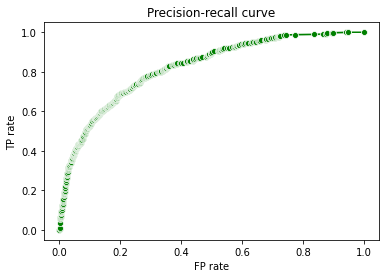

In [22]:
sns.lineplot(x=fpr_default, y=tpr_default, marker = 'o', color='green')

plt.title("Precision-recall curve")
plt.xlabel("FP rate")
plt.ylabel("TP rate")
plt.show()

ROC curve for the updated model:

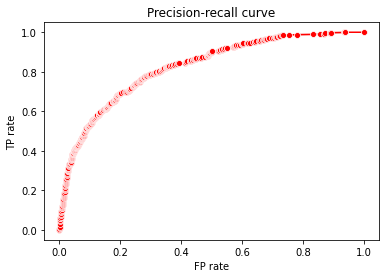

In [23]:
sns.lineplot(x=fpr_best, y=tpr_best, marker = 'o', color='red')

plt.title("Precision-recall curve")
plt.xlabel("FP rate")
plt.ylabel("TP rate")
plt.show()

Then, we use the `auc()` function to compute the area under the ROC curve for both models.

In [24]:
auc_default= auc(fpr_default, tpr_default)
auc_best= auc(fpr_best, tpr_best)

print(auc_default)
print(auc_best)

0.8227761701899632
0.8242651984031294


It can be concluded that the updated model indeed performs better than the original model with the default hyperparameter.

## Part 8: Feature Selection Using SelectKBest

Finally, we use scikit-learn's `SelectKBest` class to extract the best 5 features from the Airbnb "listings" data set to create new training data, then fit our model with the optimal hyperparameter $C$ to the data and compute the AUC.

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)
filter = selector.get_support()
top_5_features = X.columns[filter]

print("Best 5 features:")
print(top_5_features)

# Create new training and test data for features
new_X_train = X_train[top_5_features]
new_X_test = X_test[top_5_features]

# Initialize a LogisticRegression model object with the best value of hyperparameter C 
model= LogisticRegression(max_iter=1000, C=best_c)

# Fit the model to the new training data
model.fit(new_X_train, y_train)

# Make predictions on the new test data. 
proba_predictions= model.predict_proba(new_X_test)[:,1]
    
# Compute the auc-roc
fpr, tpr, thresholds = roc_curve(y_test, proba_predictions)
auc_result = auc(fpr, tpr)
print(auc_result)

Best 5 features:
Index(['has_availability', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'accommodates',
       'beds', 'minimum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_nights_avg_ntm', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month',
       'n_host_verifications', 'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Manhattan',
       'neighbourhood_group_cleansed_Staten Island',
       'room_type_Entire home/apt', 'room_type_Private room'],
      dtype='object')
0.8175173485518312
